In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import ast
import matplotlib.pyplot as plt

In [2]:
def load_data(data_path):
    df = pd.read_csv(data_path)
    # Remove null values if any
    df.dropna(inplace=True)
    print("Number of records: ",len(df))
    return df

In [3]:
df = load_data('ner.csv')

Number of records:  47959


In [4]:
def preprocess_data(df):
    for i in range(len(df)):
        pos = ast.literal_eval(df['POS'][i])
        tags = ast.literal_eval(df['Tag'][i])
        df['POS'][i] = [str(word) for word in pos]
        df['Tag'][i] = [str(word.upper()) for word in tags]
    return df

In [5]:
df = preprocess_data(df)

In [6]:
df_final = df[['Sentence', 'Tag']]

In [7]:
df_final.head()

,Sentence,Tag
0,Thousands of demonstrators have marched throug...,"[O, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GEO..."
1,Families of soldiers killed in the conflict jo...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,They marched from the Houses of Parliament to ...,"[O, O, O, O, O, O, O, O, O, O, O, B-GEO, I-GEO..."
3,"Police put the number of marchers at 10,000 wh...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,The protest comes on the eve of the annual con...,"[O, O, O, O, O, O, O, O, O, O, O, B-GEO, O, O,..."


# data preparation

In [8]:
!pip3 install collections
!pip3 install nltk

ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.6 MB/s eta 0:00:00


In [9]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
targets = list(df_final.Tag.values)
tags = set([val for sublist in targets for val in sublist])
print('Unique NER tags in the whole dataset: ', tags)

Unique NER tags in the whole dataset:  {'B-GEO', 'B-ORG', 'I-GPE', 'I-ORG', 'B-NAT', 'O', 'I-TIM', 'I-NAT', 'B-ART', 'I-ART', 'B-PER', 'I-EVE', 'B-EVE', 'I-GEO', 'B-GPE', 'I-PER', 'B-TIM'}


In [11]:
# convert sentences to sequences using the built vocabulary, then to tensors
# build vocabulary from the entire dataset

tokenized_sentences = [word_tokenize(sentence) for sentence in df_final['Sentence']]
word_counts = Counter(word for sentence in tokenized_sentences for word in sentence)
vocab = {word: index for index, (word, _) in enumerate(word_counts.most_common(), 1)}
print('Found %s unique tokens'%len(vocab))

sentences = [word_tokenize(sentence) for sentence in df_final['Sentence']]
sequences = [[vocab[word] for word in sentence] for sentence in sentences]
inputs = [torch.tensor(sequence, dtype=torch.long) for sequence in sequences]

Found 35165 unique tokens


In [12]:
# would extend the shorter tensors to the longest
max_seq_length = max(len(seq) for seq in inputs)
inputs_final = torch.stack([torch.cat([seq, torch.zeros(max_seq_length - len(seq), dtype=torch.long)]) for seq in inputs])

In [13]:
print(inputs_final.shape)

torch.Size([47959, 104])


In [14]:
# convert targets to sequences then to tensors
tgt_vocab = {'O': 0, 'B-GEO': 1, 'B-TIM': 2, 'B-ORG': 3, 'I-PER': 4, 'B-PER': 5, 'I-ORG': 6, 'B-GPE': 7, 'I-GEO': 8, 'I-TIM': 9, 'B-ART': 10, 'B-EVE': 11, 'I-ART': 12, 'I-EVE': 13, 'B-NAT': 14, 'I-GPE': 15, 'I-NAT': 16}

tgt_seq = [[tgt_vocab[tgt] for tgt in tgt_row] for tgt_row in targets]
outputs = [torch.tensor(seq, dtype=torch.long) for seq in tgt_seq]
outputs_final = torch.stack([torch.cat([seq, torch.zeros(max_seq_length - len(seq), dtype=torch.long)]) for seq in outputs])
print(outputs_final.shape)

torch.Size([47959, 104])


In [15]:
onehot_labels = nn.functional.one_hot(outputs_final, num_classes=17).float()
print(onehot_labels.shape)

torch.Size([47959, 104, 17])


In [16]:
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2
total_samples = inputs_final.size(0)
train_split = int(total_samples * train_ratio)
val_split = int(total_samples * (train_ratio + val_ratio))

train_inputs, val_inputs, test_inputs = inputs_final[:train_split], inputs_final[train_split:val_split], inputs_final[val_split:]
train_outputs, val_outputs, test_outputs = onehot_labels[:train_split], onehot_labels[train_split:val_split], onehot_labels[val_split:]
print(len(train_inputs), len(val_inputs), len(test_inputs), len(train_outputs), len(val_outputs), len(test_outputs))

28775 9592 9592 28775 9592 9592


In [17]:
batch_size = 64
train_loader = DataLoader(TensorDataset(train_inputs, train_outputs), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_inputs, val_outputs), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(test_inputs, test_outputs), batch_size=batch_size, shuffle=False)

In [18]:
len(train_loader), len(val_loader), len(test_loader)

(450, 150, 150)

# model definition

In [19]:
!pip3 install torchinfo

  Obtaining dependency information for torchinfo from https://files.pythonhosted.org/packages/72/25/973bd6128381951b23cdcd8a9870c6dcfc5606cb864df8eabd82e529f9c1/torchinfo-1.8.0-py3-none-any.whl.metadata


In [20]:
import torch
import torch.nn as nn
from torchinfo import summary

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
class RecNet(nn.Module):
    def __init__(self, embedding_dim, vocab_size, num_labels): # max_seq_len?
        super(RecNet, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=100, num_layers=2, bidirectional=True, batch_first=True) # lstm_units = 100
        self.fc = nn.Linear(2 * 100, num_labels)  # Multiply by 2 for bidirectional LSTM

    def forward(self, x):
        x = x.clone().detach().to(torch.int64)
        # x: (batch_size, seq_length)
        x = self.embedding(x)
        # x: (batch_size, seq_length, embedding_dim)
        x, _ = self.lstm(x)
        # x = x.view(-1, x.size(2)) # x: (batch_size*seq_length, hidden_size)
        # x: (batch_size, seq_length, hidden_size)
        x = self.fc(x)
        # x: (batch_size, seq_length, num_labels)
        return x

model = RecNet(embedding_dim=300, vocab_size=35165, num_labels=17)
model.to(device)

RecNet(
  (embedding): Embedding(35165, 300)
  (lstm): LSTM(300, 100, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=200, out_features=17, bias=True)
)

In [23]:
summary(model, input_size=(64, 104))

Layer (type:depth-idx)                   Output Shape              Param #
RecNet                                   [64, 104, 17]             --
├─Embedding: 1-1                         [64, 104, 300]            10,549,500
├─LSTM: 1-2                              [64, 104, 200]            563,200
├─Linear: 1-3                            [64, 104, 17]             3,417
Total params: 11,116,117
Trainable params: 11,116,117
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 4.42
Input size (MB): 0.03
Forward/backward pass size (MB): 27.53
Params size (MB): 44.46
Estimated Total Size (MB): 72.02

In [24]:
loss_fcn = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# model training

In [25]:
!pip3 install pyJoules
!pip install pynvml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 597.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.9 MB/s eta 0:00:00


In [26]:
def train(model, train_loader, loss_fcn, optimizer):
    model.train()
    running_loss = 0
    running_acc = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fcn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted_labels = torch.argmax(outputs, dim=-1)
        predicted_one_hot = nn.functional.one_hot(predicted_labels, num_classes=17).float()
        running_acc += torch.sum(torch.eq(predicted_one_hot, labels).all(dim=-1)).item()
    return running_loss / len(train_loader), running_acc / len(train_inputs)

In [27]:
def validate(model, val_loader, loss_fcn, optimizer):
    model.eval()
    running_loss = 0
    running_acc = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fcn(outputs, labels)
            running_loss += loss.item()
            predicted_labels = torch.argmax(outputs, dim=-1)
            predicted_one_hot = nn.functional.one_hot(predicted_labels, num_classes=17).float()
            running_acc += torch.sum(torch.eq(predicted_one_hot, labels).all(dim=-1)).item()
    return running_loss / len(val_loader), running_acc / len(val_inputs)

In [ ]:
from pyJoules.energy_meter import measure_energy
from pyJoules.device.rapl_device import RaplPackageDomain
from pyJoules.device.nvidia_device import NvidiaGPUDomain
from pyJoules.handler.csv_handler import CSVHandler

csv_handler = CSVHandler('train_energy_consumption.csv')

num_epochs = 50
patience = 3
best_loss = float('inf')
current_patience = 0
train_accs = []
val_accs = []
train_losses = []
val_losses = []

@measure_energy(domains=[NvidiaGPUDomain(0)],handler=csv_handler)
def wrapper_train():
    
    best_acc = -1

    for epoch in range(num_epochs):
        print(f"Epoch: {epoch+1}/{num_epochs}", end=" ")
        train_loss, train_acc = train(model, train_loader, loss_fcn, optimizer)
        val_loss, val_acc = validate(model, val_loader, loss_fcn, optimizer)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Loss: {round(train_loss, 4)} ({round(val_loss, 4)})", end=" ")
        print(f"Accuracy: {round(train_acc, 2)} ({round(val_acc, 2)})")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")
    return

wrapper_train()
csv_handler.save_data()

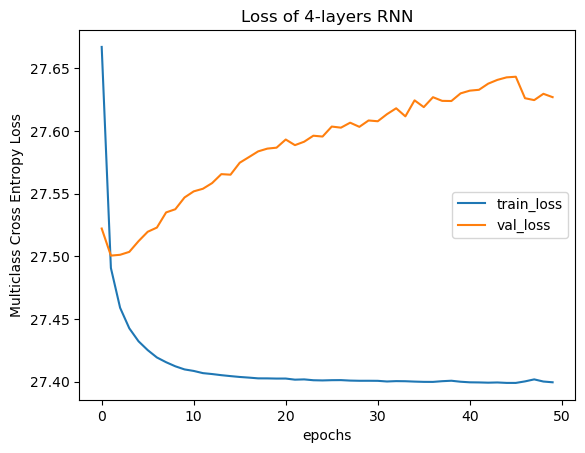

In [29]:
plt.plot(range(num_epochs), train_losses, label='train_loss')
plt.plot(range(num_epochs), val_losses, label='val_loss')
plt.title('Loss of 4-layers RNN')
plt.xlabel('epochs')
plt.ylabel('Multiclass Cross Entropy Loss')
plt.legend()

In [ ]:
plt.plot(range(num_epochs), train_accs, label='train_acc')
plt.plot(range(num_epochs), val_accs, label='val_acc')
plt.title('Accuracy of 4-layers RNN')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()

# evaluate on the test set

In [31]:
from sklearn.metrics import precision_recall_fscore_support

In [32]:
def test(model, test_loader, loss_fcn, optimizer):
    model.eval()
    running_acc = 0
    all_predictions = [] # [150, 64, 104, 17]
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predicted_labels = torch.argmax(outputs, dim=-1)
            predicted_one_hot = nn.functional.one_hot(predicted_labels, num_classes=17).float()
            running_acc += torch.sum(torch.eq(predicted_one_hot, labels).all(dim=-1)).item()
            all_predictions.extend(predicted_one_hot.cpu().numpy()) # [64, 104, 17]
            all_labels.extend(labels.cpu().numpy()) # [64, 104, 17]

    flat_all_labels = np.concatenate([arr.reshape(-1, 17) for arr in all_labels], axis=0)
    flat_all_predictions = np.concatenate([arr.reshape(-1, 17) for arr in all_predictions], axis=0)

    # flat_all_labels = torch.cat([tensor.view(-1, 17) for tensor in all_labels], dim=0)
    # flat_all_predictions = torch.cat([tensor.view(-1, 17) for tensor in all_predictions], dim=0)


    precision, recall, f1, _ = precision_recall_fscore_support(flat_all_labels, flat_all_predictions, average=None)


    return running_acc / len(test_inputs), precision, recall, f1

In [ ]:
csv_handler = CSVHandler('test_energy_consumption.csv')

@measure_energy(domains=[NvidiaGPUDomain(0)],handler=csv_handler)
def wrapper_test():
    model.load_state_dict(torch.load("best_model.pt"))
    test_acc, precision, recall, f1 = test(model, val_loader, loss_fcn, optimizer)
    print(f"Test accuracy: {test_acc:.4f}")
    return precision, recall, f1

precision, recall, f1 = wrapper_test()
csv_handler.save_data()

In [34]:
val_outputs_for_support = outputs_final[train_split:val_split]
flat_series = pd.DataFrame(val_outputs_for_support.numpy()).stack()
total_counts = flat_series.value_counts()
print(total_counts)

0     965256
1       7620
3       4122
2       4095
5       3450
6       3404
4       3394
7       3072
8       1525
9       1331
10        78
12        65
11        50
13        37
14        37
15        28
16         4
Name: count, dtype: int64


In [35]:
tag_metrics = dict()
for i, tag in enumerate(tags):
    tag_metrics[tag] = {
        'precision': precision[i],
        'recall': recall[i],
        'f1_score': f1[i],
        "support": total_counts[tgt_vocab[tag]]
    }
stats = pd.DataFrame(tag_metrics).T
stats = stats.drop('O')
print(stats)

       precision    recall  f1_score  support
B-GEO   0.997858  0.996072  0.996964   7620.0
B-ORG   0.650582  0.923622  0.763423   4122.0
I-GPE   0.895334  0.848107  0.871081     28.0
I-ORG   0.743704  0.565987  0.642788   3404.0
B-NAT   0.871161  0.685327  0.767150     37.0
I-TIM   0.800784  0.660106  0.723671   1331.0
I-NAT   0.982931  0.768555  0.862623      4.0
B-ART   0.552515  0.820984  0.660512     78.0
I-ART   0.729375  0.710744  0.719939     65.0
B-PER   0.008588  0.205128  0.016486   3450.0
I-EVE   0.444444  0.160000  0.235294     37.0
B-EVE   0.000000  0.000000  0.000000     50.0
I-GEO   0.000000  0.000000  0.000000   1525.0
B-GPE   0.135922  0.378378  0.200000   3072.0
I-PER   0.298246  0.607143  0.400000   3394.0
B-TIM   0.028571  0.250000  0.051282   4095.0


In [36]:
weighted_avg = stats.apply(lambda x: np.average(x, weights=stats["support"]))
print(weighted_avg)

precision       0.483641
recall          0.598083
f1_score        0.504366
support      4344.639081
dtype: float64
